#Pipeline for running inference and classifying pushup reps

In [1]:
import sys

sys.path.append('../data')
sys.path.append('..')
sys.path.append('../inference')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ai_trainer import Personal_Trainer
import squat_separation as ss
import pickle
import os
import random as rnd
from collections import defaultdict

%matplotlib inline

#Step 1: Instantiate our personal trainer and load preprocessed data

In [2]:
pt = Personal_Trainer('NeckY')
pt.load_squats(os.path.join('../data/data_sets','pushupDataSet109.p'))

#Step 2: Extract features 

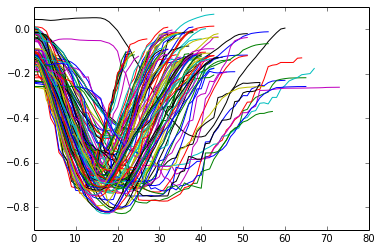

In [3]:
plt.clf()
for squat in pt.get_squats():
    plt.plot(-squat['NeckY'])

In [4]:
X, Y, file_names = pt.extract_pu_features(multiples=[0.2,0.4,0.6,0.8])

#Step 3: Classification

##Scale features and define testing functions

In [134]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
import random

def predictProbs(X,y,X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    clf.fit(X ,y)
    return clf.predict_proba(X_test)

def predict_labels(X, y, X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    try: 
        clf.fit(X ,y)
    except:
        return []
#     try:
#         print "Labels ", clf.classes_
#     except: 
#         print "Could not print classes"
    return clf.predict(X_test)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in stratified_k_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

def print_analysis(counts):
    try:
#         print 'True Negative: %f percent, %d total' % ((float(counts['0_0'])/float(counts['0_1']+counts['0_0']+counts['0_-1'])), (float(counts['0_1']) + float(counts['0_0']) + float(counts['0_-1'])))
#         print 'False Negative: %d total' % (float(counts['1_0'])+ float(counts['-1_0']))
#         print 'True Positive: %f percent, %d total' % (((float(counts['1_1']) + float(counts['-1_-1']))/float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])), (float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])))
#         print 'False Positive: %d total' % (float(counts['0_1'])+ float(counts['0_-1']))
#         print 'F-score = %f' % (2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0']))))
#         print '\n\n'
        return 2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0'])))
    except Exception as e:
        print e

def evaluate(labels, y_test, y_pred):
    if len(y_test) != len (y_pred):
        return 0
    for index, y in enumerate(y_test):
        if y_pred[index] == y:
            if y == 1:
                labels['1_1'] +=1
            elif y == 0:
                labels['0_0'] +=1
            elif y == -1:
                labels['-1_-1'] +=1
        elif y == 1:
            if y_pred[index] == 0:
                labels['1_0'] += 1
            if y_pred[index] == -1:
                labels['1_-1'] += 1
        elif y == 0:
            if y_pred[index] == -1:
                labels['0_-1'] += 1
            elif y_pred[index] == 1:
                labels['0_1'] += 1
        elif y == -1:
            if y_pred[index] == 0:
                labels['-1_0'] +=1
            elif y_pred[index] == 1:
                labels['-1_1'] += 1
        
    return metrics.accuracy_score(y_test,y_pred)


def rnd_prediction(training_data, labels, file_names, clf_class, toIgnore=None, num_iters=10, **kwargs):
    
    num_training_examples = [x*10 for x in range(1,10)]
    
    accuracy = [0 for _ in range(len(num_training_examples))]
    accuracy_train = [0 for _ in range(len(num_training_examples))]
    f_score = []
    f_score_training = []

    #=====[ Randomly leave out one of the files and test on it num_iter times ]======
    names = list(set(file_names))

    for ind, count in enumerate(num_training_examples):
        
        counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}
        training_counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}

        for name in names:
            toIgnore = name
            
            X = np.array([x for index, x in enumerate(training_data) if file_names[index] != toIgnore])
            Y = np.array([y for index, y in enumerate(labels) if file_names[index] != toIgnore])
        
            X_test = [x for index, x in enumerate(training_data) if file_names[index] == toIgnore]
            y_test = [y for index, y in enumerate(labels) if file_names[index] == toIgnore]
        
            random.seed()
            indices = random.sample(range(len(X)),count)
            X_new = X[indices]
            Y_new = Y[indices]
        
            local_accuracy = evaluate(counts, y_test, predict_labels(X_new, Y_new, X_test, clf_class, **kwargs))
            local_accuracy_train = evaluate(training_counts, Y_new, predict_labels(X_new, Y_new, X_new, clf_class, **kwargs))

            accuracy[ind] += local_accuracy
            accuracy_train[ind] += local_accuracy_train
            
        accuracy[ind]/=len(names)
        accuracy_train[ind]/=len(names)
        f_score.append(print_analysis(counts))
        f_score_training.append(print_analysis(training_counts))
        
    return f_score, f_score_training, accuracy, accuracy_train
#         f1_score += local_f1
#         print predictProbs(X,Y,X_test,clf_class,**kwargs)
#         print(toIgnore, local_accuracy)

#     print '############ TRAINING DATA ############'
#     print accuracy_train/len(names), '\n'
#     print_analysis(training_counts), '\n'
#     print '############ TEST DATA ############'
#     print accuracy/len(names), '\n'
#     print_analysis(counts),'\n\n'
#     return print_analysis(counts), accuracy/len(names), print_analysis(training_counts), accuracy_train/len(names)

In [4]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import metrics
import random

def predictProbs(X,y,X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    clf.fit(X ,y)
    return clf.predict_proba(X_test)

def predict_labels(X, y, X_test, clf_class, **kwargs):
    clf = clf_class(**kwargs)
    try: 
        clf.fit(X ,y)
    except:
        return []
#     try:
#         print "Labels ", clf.classes_
#     except: 
#         print "Could not print classes"
    return clf.predict(X_test)

def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for i, j in stratified_k_fold:
        X_train, X_test = X[i], X[j]
        y_train = y[i]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[j] = clf.predict(X_test)
    return y_pred

def print_analysis(counts):
    try:
        print 'True Negative: %f percent, %d total' % ((float(counts['0_0'])/float(counts['0_1']+counts['0_0']+counts['0_-1'])), (float(counts['0_1']) + float(counts['0_0']) + float(counts['0_-1'])))
        print 'False Negative: %d total' % (float(counts['1_0'])+ float(counts['-1_0']))
        print 'True Positive: %f percent, %d total' % (((float(counts['1_1']) + float(counts['-1_-1']))/float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])), (float(counts['-1_1']+counts['-1_-1']+counts['-1_0']+counts['1_1']+counts['1_-1']+counts['1_0'])))
        print 'False Positive: %d total' % (float(counts['0_1'])+ float(counts['0_-1']))
        print 'F-score = %f' % (2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0']))))
        print '\n\n'
        return 2*(float(counts['1_1']) + float(counts['-1_-1']))/(2*(float(counts['1_1']) + float(counts['-1_-1'])) + (float(counts['0_1'])+ float(counts['0_-1'])) + (float(counts['1_0'])+ float(counts['-1_0'])))
    except Exception as e:
        print e

def evaluate(labels, y_test, y_pred):
    if len(y_test) != len (y_pred):
        return 0
    for index, y in enumerate(y_test):
        if y_pred[index] == y:
            if y == 1:
                labels['1_1'] +=1
            elif y == 0:
                labels['0_0'] +=1
            elif y == -1:
                labels['-1_-1'] +=1
        elif y == 1:
            if y_pred[index] == 0:
                labels['1_0'] += 1
            if y_pred[index] == -1:
                labels['1_-1'] += 1
        elif y == 0:
            if y_pred[index] == -1:
                labels['0_-1'] += 1
            elif y_pred[index] == 1:
                labels['0_1'] += 1
        elif y == -1:
            if y_pred[index] == 0:
                labels['-1_0'] +=1
            elif y_pred[index] == 1:
                labels['-1_1'] += 1
        
    return metrics.accuracy_score(y_test,y_pred)


def rnd_prediction(training_data, labels, file_names, clf_class, toIgnore=None, num_iters=10, **kwargs):
    
    
    accuracy = 0
    accuracy_train = 0

    #=====[ Randomly leave out one of the files and test on it num_iter times ]======
    names = list(set(file_names))
        
    counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}
    training_counts = {'-1_1':0,'-1_-1':0,'-1_0':0,'0_0':0,'0_1':0,'0_-1':0, '1_0':0, '1_-1':0, '1_1':0}

    for name in names:
        toIgnore = name

        X = np.array([x for index, x in enumerate(training_data) if file_names[index] != toIgnore])
        Y = np.array([y for index, y in enumerate(labels) if file_names[index] != toIgnore])

        X_test = [x for index, x in enumerate(training_data) if file_names[index] == toIgnore]
        y_test = [y for index, y in enumerate(labels) if file_names[index] == toIgnore]


        local_accuracy = evaluate(counts, y_test, predict_labels(X, Y, X_test, clf_class, **kwargs))
        local_accuracy_train = evaluate(training_counts, Y, predict_labels(X, Y, X, clf_class, **kwargs))

        accuracy += local_accuracy
        accuracy_train += local_accuracy_train

    print '############ TRAINING DATA ############'
    print accuracy_train/len(names), '\n'
    print_analysis(training_counts), '\n'
    print '############ TEST DATA ############'
    print accuracy/len(names), '\n'
    print_analysis(counts),'\n\n'
#     return print_analysis(counts), accuracy/len(names), print_analysis(training_counts), accuracy_train/len(names)

##Test Various Classifiers

In [5]:
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

##Build classifier for each feature set and test against individuals that have no input into the training set

In [6]:
def classify(feature_key, data_dir):
    print('Logistic Regression:           {:.2f}'.format(rnd_prediction(feature_key, data_dir, linear_model.LogisticRegression)))
    print('Support vector machine(SVM):   {:.2f}'.format(rnd_prediction(feature_key, data_dir, svm.SVC)))
    print('Random Forest Classifier:      {:.2f}'.format(rnd_prediction(feature_key, data_dir, ensemble.RandomForestClassifier)))

#Classify with file_names left out

In [12]:
for key in Y:
    x = X
    y = Y[key]
    try:
        print '\n\n', key, '\n#############################\n\n'
        print 'Logistic Regression'
        print '#############################\n'
        rnd_prediction(x, y, file_names, linear_model.LogisticRegression, penalty='l1')
        print 'SVM'
        rnd_prediction(x, y, file_names, svm.SVC)
        print 'Random Forest Classifier Optimized'
        rnd_prediction(x, y, file_names, ensemble.RandomForestClassifier, max_depth=8)
#         print 'Random Forest Classifier'
#         rnd_prediction(x, y, file_names, ensemble.RandomForestClassifier)
        print 'Gradient Boosting'
        rnd_prediction(x, y, file_names, GradientBoostingClassifier, n_estimators = 100, learning_rate = 0.1)
        print 'Decision Tree'
        rnd_prediction(x, y, file_names, tree.DecisionTreeClassifier)
    except Exception as e:
        print key, e



head_back 
#############################


Logistic Regression
#############################

############ TRAINING DATA ############
0.997245179063 

True Negative: 0.996825 percent, 630 total
False Negative: 1 total
True Positive: 0.997826 percent, 460 total
False Positive: 2 total
F-score = 0.996743



############ TEST DATA ############
0.572727272727 

True Negative: 0.682540 percent, 63 total
False Negative: 26 total
True Positive: 0.434783 percent, 46 total
False Positive: 20 total
F-score = 0.465116



SVM
############ TRAINING DATA ############
0.962396694215 

True Negative: 0.963492 percent, 630 total
False Negative: 18 total
True Positive: 0.960870 percent, 460 total
False Positive: 23 total
F-score = 0.955676



############ TEST DATA ############
0.4 

True Negative: 0.555556 percent, 63 total
False Negative: 37 total
True Positive: 0.195652 percent, 46 total
False Positive: 28 total
F-score = 0.216867



Random Forest Classifier Optimized
############ TRAINING DATA ###

#Classification Experimentation with varying sizes of states

In [7]:
X0, Y0, file_names = pt.extract_pu_features(multiples=[0.5])

In [35]:
X00 = np.concatenate([X0[x] for x in X0],axis=1)

In [9]:
X1, Y1, file_names = pt.extract_pu_features(multiples=[0.25, 0.5, 0.75])

In [34]:
X10 = np.concatenate([X1[x] for x in X1],axis=1)

In [12]:
X15, Y15, file_names = pt.extract_pu_features(multiples=[0.2, 0.4, 0.6, 0.8])

In [33]:
X150 = np.concatenate([X15[x] for x in X15],axis=1)

In [16]:
X2, Y2, file_names = pt.extract_pu_features(multiples=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [31]:
X20 = np.concatenate([X2[x] for x in X2],axis=1)

In [24]:
X3, Y3, file_names = pt.extract_pu_features(multiples=[0.05, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

In [32]:
X30 = np.concatenate([X3[x] for x in X3],axis=1)

In [42]:
X4, Y4, file_names = pt.extract_pu_features(multiples=[float(x)/100 for x in range(100)])

In [43]:
X40 = np.concatenate([X4[x] for x in X4],axis=1)

In [126]:
# for key in Y:
key = 'elbow_angle'

y = Y0[key]

X=X3[key]

try:
    print '\n\n', key, '\n######################################\n\n'
    print 'Logistic Regression with L1'
    rnd_prediction(X, y, file_names, linear_model.LogisticRegression, penalty='l1')
    print 'SVM'
    rnd_prediction(X, y, file_names, svm.SVC, C=8)
    print 'Random Forest Classifier Optimized'
    rnd_prediction(X, y, file_names, ensemble.RandomForestClassifier, max_depth=10)
    print 'Random Forest Classifier'
    rnd_prediction(X, y, file_names, ensemble.RandomForestClassifier)
    print 'Gradient Boosting estimators plus learning rate'
    rnd_prediction(X, y, file_names, GradientBoostingClassifier, n_estimators = 100, learning_rate = 0.1)
    print 'Decision Tree w/ min_samples_split = 5 and entropy'
    rnd_prediction(X, y, file_names, tree.DecisionTreeClassifier, min_samples_split= 3, criterion="entropy")

except Exception as e:
    print key, e



elbow_angle 
######################################


Logistic Regression with L1
############ TRAINING DATA ############
0.967887970615 

True Negative: 1.000000 percent, 950 total
False Negative: 35 total
True Positive: 0.750000 percent, 140 total
False Positive: 0 total
F-score = 0.857143



############ TEST DATA ############
0.963636363636 

True Negative: 0.989474 percent, 95 total
False Negative: 3 total
True Positive: 0.785714 percent, 14 total
False Positive: 1 total
F-score = 0.846154



SVM
############ TRAINING DATA ############
0.979816345271 

True Negative: 1.000000 percent, 950 total
False Negative: 22 total
True Positive: 0.842857 percent, 140 total
False Positive: 0 total
F-score = 0.914729



############ TEST DATA ############
0.918181818182 

True Negative: 1.000000 percent, 95 total
False Negative: 9 total
True Positive: 0.357143 percent, 14 total
False Positive: 0 total
F-score = 0.526316



Random Forest Classifier Optimized
############ TRAINING DATA ########

#Best performing classifiers pushup Components

In [157]:
#=====[ Best Classifier for Head-Back Alignment ]=====
print 'Logistic Regression with L1'
rnd_prediction(X40, Y0['head_back'], file_names, linear_model.LogisticRegression, penalty='l2')

Logistic Regression with L1


([0.35294117647058826,
  0.45161290322580644,
  0.43373493975903615,
  0.6055045871559633,
  0.6326530612244898,
  0.62,
  0.5773195876288659,
  0.5918367346938775,
  0.5625],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.29090909090909095,
  0.52828282828282824,
  0.56464646464646473,
  0.59999999999999998,
  0.66363636363636358,
  0.64646464646464641,
  0.61919191919191918,
  0.62828282828282833,
  0.60909090909090913],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [127]:
#=====[Best Classifier for Knees Straight ]=====
print 'Logistic Regression with L1'
rnd_prediction(X30, Y0['knees_straight'], file_names, linear_model.LogisticRegression, penalty='l1')

Logistic Regression with L1
############ TRAINING DATA ############
0.990826446281 

True Negative: 0.998947 percent, 950 total
False Negative: 9 total
True Positive: 0.935714 percent, 140 total
False Positive: 1 total
F-score = 0.963235



############ TEST DATA ############
0.9 

True Negative: 0.947368 percent, 95 total
False Negative: 6 total
True Positive: 0.571429 percent, 14 total
False Positive: 5 total
F-score = 0.592593





In [184]:
#=====[ Best Classifier for Elbow Angle ]=====

print 'Logistic Regression with L1'
rnd_prediction(X3[key], y, file_names, linear_model.LogisticRegression, penalty='l1')

Logistic Regression with L1


([0.2222222222222222,
  0.6666666666666666,
  0.8333333333333334,
  0.18181818181818182,
  0.6666666666666666,
  0.75,
  0.5,
  0.8148148148148148,
  0.8],
 [0.9285714285714286,
  0.9333333333333333,
  0.9113924050632911,
  0.9090909090909091,
  0.8732394366197183,
  0.8513513513513513,
  0.8488372093023255,
  0.8472906403940886,
  0.8761061946902655],
 [0.69090909090909092,
  0.83636363636363631,
  0.96363636363636362,
  0.83636363636363631,
  0.90909090909090906,
  0.94545454545454544,
  0.90909090909090906,
  0.95454545454545459,
  0.95454545454545459],
 [0.80000000000000004,
  0.89545454545454561,
  0.97878787878787887,
  0.97727272727272729,
  0.96727272727272728,
  0.96666666666666645,
  0.96623376623376622,
  0.96477272727272734,
  0.97171717171717187])

#Plot Accuracy and F-Score vs. Number of States

In [178]:
#=====[ Store f_scores and accuracies for test and training data ]=====
f_score = []
f_score_t = []
accuracy = []
accuracy_t = []

#=====[ Iterate through iterations to converge ]=====
num_iters = 40
for _ in range(0,num_iters):
    f, ft, a, at = rnd_prediction(X3[key], y, file_names, linear_model.LogisticRegression, penalty='l1')
    f_score.append(f)
    f_score_t.append(ft)
    accuracy.append(a)
    accuracy_t.append(at)

float division by zero
float division by zero


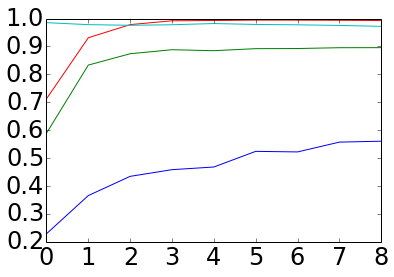

In [180]:
         
plt.plot([np.average(l) for l in zip(*list(f_score))])
plt.plot([np.average(l) for l in zip(*list(accuracy))])
plt.plot([np.average(l) for l in zip(*list(accuracy_t))])
plt.plot([np.average(l) for l in zip(*list(f_score_t))])

f = [np.average(l) for l in zip(*list(f_score))]
ft = [np.average(l) for l in zip(*list(f_score_t))]
a = [np.average(l) for l in zip(*list(accuracy))]
at = [np.average(l) for l in zip(*list(accuracy_t))]

In [181]:
# avgs = pickle.load(open('Average F1-Scorea and Accuracy Squat.png','rb'))
# avgsf = avgs[0]
# avgsft = avgs[1]
# avgsa = avgs[2]
# avgsat = avgs[3]

In [182]:
# Only use this if you wish to add to existing f1 and average scores

# avgsf.append([np.average(l) for l in zip(*list(f_score))])
# avgsft.append([np.average(l) for l in zip(*list(f_score_t))])
# avgsa.append([np.average(l) for l in zip(*list(accuracy))])
# avgsat.append([np.average(l) for l in zip(*list(accuracy_t))])

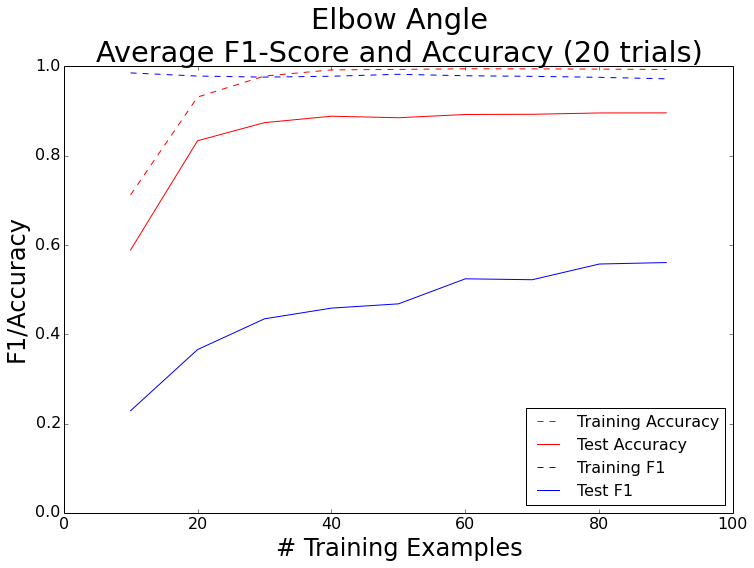

In [185]:
plot_keys = ['back_hip_angle', 'bend_hips_knees', 'stance_width', 'squat_depth','knees_over_toes']
num_training_examples = [x*10 for x in range(1,10)]
colors= ['k','r','r','b','g']

plt.plot(num_training_examples, at, color='r', linestyle='--', label='Training Accuracy')
plt.plot(num_training_examples, a, color='r', label='Test Accuracy')
plt.plot(num_training_examples, ft, color='b', linestyle='--', label='Training F1')
plt.plot(num_training_examples, f, color='b', label='Test F1')

plt.legend(loc='lower right', prop={'size':16})
plt.title('Elbow Angle \nAverage F1-Score and Accuracy (20 trials)')
plt.xlabel('# Training Examples')
plt.ylabel('F1/Accuracy')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axis([0, 100, 0, 1.0])
figure.savefig("elbow_angle.png", dpi = 200)

In [241]:
# pickle.dump([avgsf, avgsft, avgsa, avgsat],open('Average F1-Scorea and Accuracy Squat.png','wb'))